# Data preparation section

In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [2]:
import numpy as np
import pandas as pd

In [3]:
import opensmile

smile = opensmile.Smile(
    feature_set=opensmile.FeatureSet.ComParE_2016,
    feature_level=opensmile.FeatureLevel.Functionals,
)


In [4]:
import glob

files = glob.glob("../data/raw/RAVDESS/*/*.wav")

In [5]:
file_name_to_emotion_mapping = {
    "01": "neutral",
    "02": "calm",
    "03": "happy",
    "04": "sad",
    "05": "angry",
    "06": "fearful",
    "07": "disgust",
    "08": "surprised",
}

In [74]:
emotion_to_positivity_mapping = {
    "neutral": "positive",
    "calm": "positive",
    "happy": "positive",
    "sad": "negative",
    "angry": "negative",
    "fearful": "negative",
    "disgust": "negative",
    "surprised": "positive",
}

##### Data reading and normalisation

In [6]:
speech_data = smile.process_files(files)

In [7]:
normalised_speech_data=(speech_data-speech_data.mean())/speech_data.std()
normalised_speech_data.dropna(axis='columns', inplace=True)

In [72]:
emotion_labels = [file_name_to_emotion_mapping[file.split("-")[-5]] for file in files]

##### Splitting the data into training, validation and test sets

In [11]:
from sklearn.model_selection import train_test_split

speeches = normalised_speech_data
emotions = emotion_labels

speeches_train_and_val, speeches_test, emotions_train_and_val, emotions_test = train_test_split(speeches, emotions, test_size=0.2, random_state=42, stratify=emotions)
speeches_train, speeches_val, emotions_train, emotions_val = train_test_split(speeches_train_and_val, emotions_train_and_val, test_size=0.25, random_state=42, stratify=emotions_train_and_val)

In [75]:
emotions_binary_train = [emotion_to_positivity_mapping[emotion] for emotion in emotions_train]
emotions_binary_val = [emotion_to_positivity_mapping[emotion] for emotion in emotions_val]
emotions_binary_test = [emotion_to_positivity_mapping[emotion] for emotion in emotions_test]

In [13]:
# Pandas dataframes keep the old indexing after sampling, but I need it to be sequential, thus, a reset for the index
speeches_train.reset_index(drop=True, inplace=True)
speeches_val.reset_index(drop=True, inplace=True)
speeches_test.reset_index(drop=True, inplace=True)

In [14]:
from collections import Counter

print(f"{len(speeches_train)=}\t\t{len(emotions_train)=}")
print(f"{len(speeches_val)=}\t\t{len(emotions_val)=}")
print(f"{len(speeches_test)=}\t\t{len(emotions_test)=}")

print(f"{Counter(emotions_train)=}")
print(f"{Counter(emotions_val)=}")
print(f"{Counter(emotions_test)=}")

len(speeches_train)=864		len(emotions_train)=864
len(speeches_val)=288		len(emotions_val)=288
len(speeches_test)=288		len(emotions_test)=288
Counter(emotions_train)=Counter({'calm': 116, 'angry': 115, 'fearful': 115, 'sad': 115, 'happy': 115, 'surprised': 115, 'disgust': 115, 'neutral': 58})
Counter(emotions_val)=Counter({'sad': 39, 'disgust': 39, 'angry': 39, 'calm': 38, 'surprised': 38, 'fearful': 38, 'happy': 38, 'neutral': 19})
Counter(emotions_test)=Counter({'happy': 39, 'fearful': 39, 'surprised': 39, 'sad': 38, 'calm': 38, 'angry': 38, 'disgust': 38, 'neutral': 19})


# Classifier comparison section

##### Building classifiers

In [60]:
from locale import Error
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn import metrics

def fit_predict_and_score_classifier(classifier, data_train, data_val, labels_train, labels_val, label_set):
    classifier.fit(data_train, labels_train)
    results = {"train": {}, "val": {}}

    for set_type in ["train", "val"]:
        if set_type == "train":
            data = data_train
            labels = labels_train
        elif set_type == "val":
            data = data_val
            labels = labels_val
        else:
            raise Error("Undefined data set type")

        labels_predicted = classifier.predict(data)

        results[set_type]["predictions"] = labels_predicted
        results[set_type]["accuracy"] = metrics.accuracy_score(labels, labels_predicted)
        results[set_type]["precision"] = metrics.precision_score(labels, labels_predicted, average="macro", zero_division=1)
        results[set_type]["recall"] = metrics.recall_score(labels, labels_predicted, average="macro", zero_division=1)
        results[set_type]["F1"] = metrics.f1_score(labels, labels_predicted, average="macro", zero_division=1)

    return results

def create_result_table(results):
    first_key = list(results.keys())[0]
    second_key = list(results[first_key].keys())[0]
    table = pd.DataFrame(columns=["Classifier", "Set type"] + list(results[first_key][second_key].keys()))
    for classifier_name, classifier_data in results.items():
        for set_type, set_metrics in classifier_data.items():
              # Taken from (merging dicts) https://stackoverflow.com/questions/38987/how-do-i-merge-two-dictionaries-in-a-single-expression-in-python
            new_row = {"Classifier": classifier_name, "Set type": set_type} | set_metrics
            table = table.append(new_row, ignore_index=True)
    return table

# def create_result_table(results):
#     first_key = list(results.keys())[0]
#     second_key = list(results[first_key].keys())[0]
#     table = pd.DataFrame(columns=["Classifier", "Set type"] + list(results[first_key][second_key].keys()))
#     for classifier_name, classifier_data in results.items():
#         for set_type, set_metrics in classifier_data.items():
#               # Taken from (merging dicts) https://stackoverflow.com/questions/38987/how-do-i-merge-two-dictionaries-in-a-single-expression-in-python
#             new_row = pd.DataFrame({"Classifier": classifier_name, "Set type": set_type} | set_metrics)
#             table = pd.concat([table, new_row], ignore_index=True)
#     return table

def calculate_f1_scores_by_class(labels_predicted, labels):
    all_labels = sorted(list(set(labels)))
    matrix_dimension = range(len(set(labels)))
    matrix = metrics.confusion_matrix(labels, labels_predicted, labels=all_labels)

    recalls = [matrix[index, index] / row_sum for index, row_sum in enumerate(np.sum(matrix, axis=1))]
    precisions = [matrix[index, index] / column_sum for index, column_sum in enumerate(np.sum(matrix, axis=0))]

    f1_scores = {label: {} for label in all_labels}
    for index, label in enumerate(all_labels):
        f1_scores[label] = 2 * (precisions[index] * recalls[index]) / (precisions[index] + recalls[index])

    return f1_scores

In [78]:
# These parameters are repeated, so they are unwrapped while calling functions to reduce clutter
multi_class_parameters = (speeches_train, speeches_val, emotions_train, emotions_val, set(emotions))
binary_parameters = (speeches_train, speeches_val, emotions_binary_train, emotions_binary_val, set(["positive", "negative"]))
initial_classifier_results = {}

In [79]:
dummy_classifier_most_frequent = DummyClassifier(strategy="most_frequent")
initial_classifier_results["dummy_classifier_most_frequent"] = fit_predict_and_score_classifier(dummy_classifier_most_frequent, *multi_class_parameters)

In [80]:
dummy_classifier_stratified = DummyClassifier(strategy="stratified")
initial_classifier_results["dummy_classifier_stratified"] = fit_predict_and_score_classifier(dummy_classifier_stratified, *multi_class_parameters)

In [89]:
logistic_regression = LogisticRegression(max_iter=1000)
initial_classifier_results["logistic_regression"] = fit_predict_and_score_classifier(logistic_regression, *multi_class_parameters)

In [90]:
svc_classifier = SVC()
initial_classifier_results["svc"] = fit_predict_and_score_classifier(svc_classifier, *multi_class_parameters)

In [91]:
initial_classifier_results_table = create_result_table(initial_classifier_results)
display(initial_classifier_results_table)

C:\Users\Matas\AppData\Local\Temp\ipykernel_28668\565030620.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table = table.append(new_row, ignore_index=True)
C:\Users\Matas\AppData\Local\Temp\ipykernel_28668\565030620.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table = table.append(new_row, ignore_index=True)
C:\Users\Matas\AppData\Local\Temp\ipykernel_28668\565030620.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table = table.append(new_row, ignore_index=True)
C:\Users\Matas\AppData\Local\Temp\ipykernel_28668\565030620.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table = table.append(new_row, ignore_index=Tr

,Classifier,Set type,predictions,accuracy,precision,recall,F1
0,dummy_classifier_most_frequent,train,"[calm, calm, calm, calm, calm, calm, calm, cal...",0.134259,0.891782,0.125000,0.029592
1,dummy_classifier_most_frequent,val,"[calm, calm, calm, calm, calm, calm, calm, cal...",0.131944,0.891493,0.125000,0.029141
2,dummy_classifier_stratified,train,"[surprised, angry, happy, surprised, sad, calm...",0.108796,0.103987,0.104198,0.103944
3,dummy_classifier_stratified,val,"[sad, happy, calm, surprised, angry, sad, disg...",0.125000,0.120601,0.123819,0.121318
4,logistic_regression,train,"[angry, fearful, neutral, sad, happy, surprise...",1.000000,1.000000,1.000000,1.000000
5,logistic_regression,val,"[calm, calm, surprised, sad, fearful, sad, neu...",0.680556,0.683352,0.677800,0.677776
6,svc,train,"[happy, fearful, neutral, sad, happy, surprise...",0.971065,0.968848,0.966436,0.967431
7,svc,val,"[sad, calm, surprised, sad, fearful, sad, neut...",0.604167,0.611779,0.586791,0.585068


In [92]:
f1_scores = calculate_f1_scores_by_class(initial_classifier_results["svc"]["val"]["predictions"], emotions_val)
for emotion, score in f1_scores.items():
    print(f"{emotion}: {score}")

angry: 0.6
calm: 0.6799999999999999
disgust: 0.6301369863013699
fearful: 0.5970149253731344
happy: 0.5135135135135136
neutral: 0.41379310344827586
sad: 0.47500000000000003
surprised: 0.7710843373493975


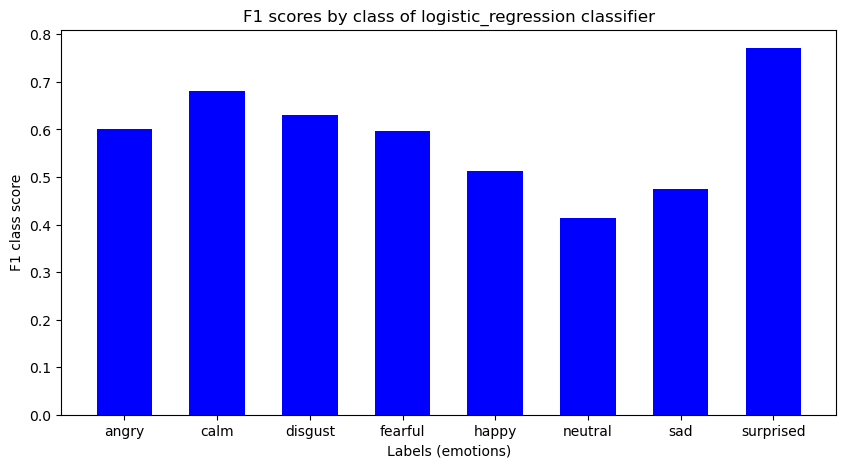

In [93]:
# Taken from https://www.geeksforgeeks.org/bar-plot-in-matplotlib/

import matplotlib.pyplot as plt

list_of_emotions = list(f1_scores.keys())
f1_score_values = list(f1_scores.values())

fig = plt.figure(figsize = (10, 5))

plt.bar(list_of_emotions, f1_score_values, color ='blue', width = 0.6)
plt.xlabel("Labels (emotions)")
plt.ylabel("F1 class score")
plt.title("F1 scores by class of logistic_regression classifier")
plt.show()

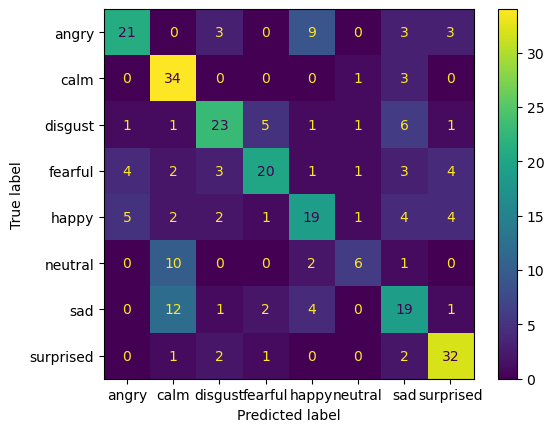

In [94]:
from sklearn import metrics

metrics.ConfusionMatrixDisplay.from_predictions(emotions_val, initial_classifier_results["svc"]["val"]["predictions"])
plt.show()